## Homework on Modern Convolutional Neural Networks

### Description
I used 10+ different models, each training lasted over 1 hour. Tried convolutions with kernel 7, 5, 3. Ended with hybrid kernel 53333. Also increased batch size from default 64 to 128. Final, best performing model has number 10 and it is `Kernel5WithThinLayersCNN`. Training charts in the end are for this model. I stopped training, because loss on validation set started showing not good results.

Ended with 5 conv layers and several not very wide fc layers (2048 neurons is max (tried more and less, both perform worse)).

Charts and results for intermediate models are present in corresponding cells.

## Baseline solution

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [89]:
import os
import pickle
import cv2
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [90]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset

The data is in the [Data](https://www.kaggle.com/competitions/nup-ml-1-2023-image-classification/data) section of the kaggle competition. <br>
You need to download the archive with the data and unzip it. <br>
In the variable below, specify the path to the dataset. <br>

In [91]:
dataset_root = "/Users/es/Desktop/NUP/STUDYING/ml-hard-artificial-intelligence/data-science-things/ml_with_python/image-classification/image-comp-data"

Code for loading the modified SVHN dataset. Initialization Arguments:

- `root` — string, path to directory with dataset files
- `is_train` — flag, load part for training or test
- `transform` — image transformations
- `target_transform` — image class transformations

In [92]:
class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Dataset download

In [93]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=ToTensor(),
)
for i in trange(len(data.data)):
    data.data[i] = cv2.medianBlur((data.data[i]).astype(np.uint8), 3)

100%|██████████| 50000/50000 [00:00<00:00, 69097.98it/s]


We randomly split the dataset into training and validation. <br>
In the first part, we will train the classification model. <br>
In the second part, we will evaluate the quality during the experiments. <br>

In [94]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

Data loaders initialization.

In [95]:
batch_size = 128 # 64 is default
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Let's see what size batches the data loader produces.

In [96]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.uint8


In [97]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Classification model (acc 0.21)

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 10),
)
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=10, bias=True)
)
Total Trainable Parameters: 30730


### AlexNetLight model (acc 0.19)

In [81]:
class AlexNetLight(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetLight, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # Reduced number of filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Reduced number of filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Reduced number of filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 6 * 6, 1024), # Reduced size of linear layers
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 128 * 6 * 6)
        x = self.classifier(x)
        return x

model = AlexNetLight(num_classes=10)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
AlexNetLight(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 4823114


### CustomCNN model (acc 0.13)

In [54]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128), # Adjust the input features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10) # 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the output for the dense layer
        x = self.fc_layers(x)
        return x

model = CustomCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 545290


### ReworkedCNN model (acc 0.701 after 20 epochs, with default optimizer and without scheduler)

In [89]:
class ReworkedCNN(nn.Module):
    def __init__(self):
        super(ReworkedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self._to_linear = None
        self.convs(torch.randn(64, 3, 32, 32))
        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def convs(self, x):
        x = self.conv_layers(x)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = ReworkedCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
ReworkedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features

### AdvancedCNN (acc 0.809, 26/50 epochs)
Better, but there is still room for improvement. 
![advanced_charts.png](/ml_with_python/image-classification/image-comp-data/advanced_charts.png)

In [96]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # Additional layers
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the tensor
        x = self.fc_layers(x)
        return x
    
model = AdvancedCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
AdvancedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, 

### MoreLikeAlexNetCNN model (acc 0.861, batch size = 128, added blur into photos, epochs 27/43 1:13:36, 163.57s/it)
![more_like_alex_net_charts.png](/ml_with_python/image-classification/image-comp-data/more_like_alex_net_charts.png)


In [98]:
class MoreLikeAlexNetCNN(nn.Module):
    def __init__(self):
        super(MoreLikeAlexNetCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # Using max pooling for downsampling
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # Using max pooling for downsampling
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # Additional max pooling layer for further downsampling
        )
        # The fully connected layer sizes would need to be adjusted based on the output size of the last conv layer
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # Adjusted based on the new output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = self.fc_layers(x)
        return x


model = MoreLikeAlexNetCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
MoreLikeAlexNetCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, str

### SlightlyMoreComplexLikeAlexNetCNN model (acc 0.85, batch size = 128, added blur into photos, epochs 25, ????, ?????s/it)
![SlightlyMoreComplexLikeAlexNetCNN_charts.png](/ml_with_python/image-classification/image-comp-data/SlightlyMoreComplexLikeAlexNetCNN_charts.png)

In [99]:
class SlightlyMoreComplexLikeAlexNetCNN(nn.Module):
    def __init__(self):
        super(SlightlyMoreComplexLikeAlexNetCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc_layers(x)
        return x
    
model = SlightlyMoreComplexLikeAlexNetCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
SlightlyMoreComplexLikeAlexNetCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(256

### Kernel5WithThinLayersCNN model (acc 0.89, batch size = 128, added blur into photos, epochs 32/80, 2:57:12, 332.25s/it)


In [161]:
class Kernel5WithThinLayersCNN(nn.Module):
    def __init__(self):
        super(Kernel5WithThinLayersCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),  # Decreased width
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x
    
model = Kernel5WithThinLayersCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model = model.to(device)
print(model)
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Using cpu device
Kernel5WithThinLayersCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(256, 128, ke

### Training

We set the loss function (optimization goal) and the optimizer.

In [162]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Code for visualizing the learning process.

Every `interval` optimization steps and at the end of epochs, we write the values of the loss function and metrics to the log. <br>
Then, by calling the `show_progress` function, we update the training schedule. <br>

In [163]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [164]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [165]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)


In [166]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

Training loop.

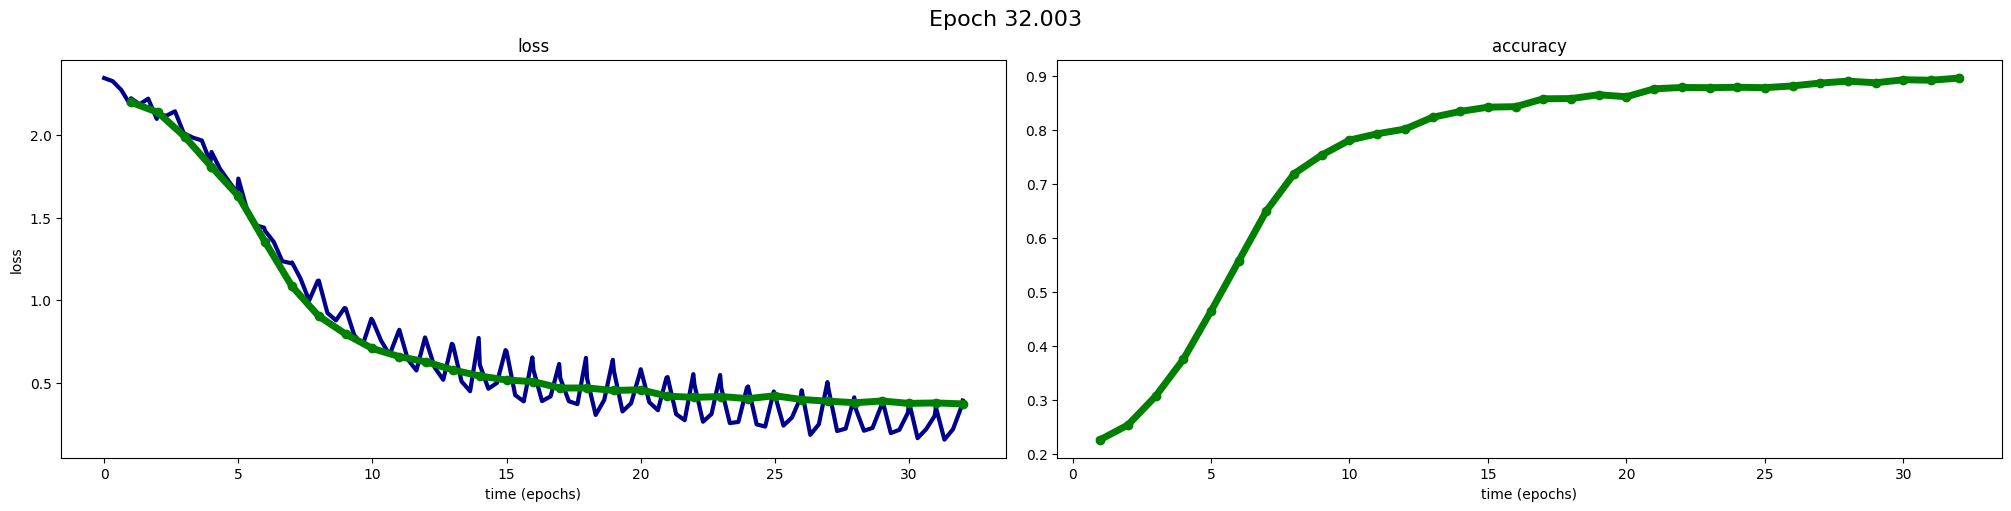

 40%|████      | 32/80 [2:57:12<4:25:48, 332.25s/it]


KeyboardInterrupt: 

In [167]:
print(total_params)
epochs = 80 
for t in trange(epochs):
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

In [168]:
torch.save(model.state_dict(), f"{dataset_root}/final_model_v_10_kernel_5_thinner")

### Submit solution

Download the test part of the dataset.

In [169]:
test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=ToTensor(),
)
for i in trange(len(test_data.data)):
    test_data.data[i] = cv2.medianBlur((test_data.data[i]).astype(np.uint8), 3)

100%|██████████| 25000/25000 [00:00<00:00, 73160.16it/s]


In [170]:
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

We make predictions by the final model.

In [171]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

We form a solution file to submit to Kaggle.

In [172]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            
write_solution(f"{dataset_root}/solution_10_kernel_5_thinner.csv", predictions)